# 生物大数据分析课程设计源代码

项目名称：通过深度学习对癫痫脑电波信号进行分类

项目成员：叶佳晨、吴玥汀、石京成、谢乐凡、韩德坤

## 导入所需的库

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model, Input, load_model
from keras.layers import Dense, Dropout, LSTM, Bidirectional, GRU, Conv1D, BatchNormalization, Input, concatenate, SpatialDropout1D, GlobalAveragePooling1D, MaxPooling1D, Softmax, Activation
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from keras import regularizers
from keras.layers.core import Masking

## 数据处理

In [2]:
# 对标签进行独热编码
label_dic = {
    "normal": (1, 0, 0), # 健康人
    "inter": (0, 1, 0), # 患病但未发作
    "ictal": (0, 0, 1) # 患病且发作
}
# 文件夹路径
path = "./EEG_data/"
# 滑动窗口大小
window_size = 256
# 滑动步长
step_size = 128
# 测试集比例
test_size = 0.2


# 读取目标文件夹中的所有文件
def folder_to_df(letter):
    full_path = path + letter + "/*.*"
    files = glob (full_path)
    df_list = []
    for file in files:
        df_list.append (pd.read_csv (file, header = None))
    big_df = pd.concat (df_list, ignore_index=True, axis= 1)

    return big_df.T

# 窗口切割，窗口大小为256，步长为128
def window (a, w = 256, o = 128):
    view = []
    for i in range (0, a.shape[0] - w, o):
        sub = a[i:i+w]
        """
        MinMax = np.ptp (sub)
        sub = (sub - np.mean (sub)) / np.std (sub)
        sub = list (sub)
        sub.append (MinMax)
        """
        view += [sub]
    
    return view.copy()

# 数据扩充
def enrich_data (df): 
    res = []
    for i in range (df.shape[0]):
        res += [window (df.iloc[i].values, w = window_size, o = step_size)]
    return res

# 读取所有的文件夹
def load_data_as_df():
    A = folder_to_df('Z')
    B = folder_to_df('O')
    C = folder_to_df('N')
    D = folder_to_df('F')
    E = folder_to_df('S')
    
    normal = A.append (B).reset_index(drop = True)
    interictal = C.append (D).reset_index(drop = True)
    ictal = E

    return normal, interictal, ictal

# 数据格式转换
def format_enrich_data(normal, interictal, ictal):
    
    # 对扩充后的数据集进行维度转换
    normal_data_enr = np.asarray (enrich_data(normal)).reshape(-1, np.asarray(enrich_data(normal)).shape[-1])
    interictal_data_enr = np.asarray (enrich_data(interictal)).reshape(-1, np.asarray(enrich_data(interictal)).shape[-1])
    ictal_data_enr = np.asarray (enrich_data(ictal)).reshape(-1, np.asarray(enrich_data(ictal)).shape[-1])

    # 更换数据形式
    normal_data_enr_df = pd.DataFrame(normal_data_enr)
    interictal_data_enr_df = pd.DataFrame(interictal_data_enr)
    ictal_data_enr_df = pd.DataFrame(ictal_data_enr)
    
    # 打标签
    normal_data_enr_lab = pd.DataFrame ([label_dic['normal'] for _ in range (normal_data_enr.shape[0])])
    interictal_data_enr_lab = pd.DataFrame ([label_dic['inter'] for _ in range (interictal_data_enr.shape[0])])
    ictal_data_enr_lab = pd.DataFrame ([label_dic['ictal'] for _ in range (ictal_data_enr.shape[0])])

    # 拼接并划分出数据与标签
    data = pd.concat([normal_data_enr_df, interictal_data_enr_df, ictal_data_enr_df], ignore_index = True)
    labels = pd.concat([normal_data_enr_lab, interictal_data_enr_lab, ictal_data_enr_lab], ignore_index = True)
    
    return data.values, labels.values

# 对于RNN类的模型需要进行数据shape的转变
def rnn_transform (raw_dat, frame_size = 1):
    if raw_dat.shape[1] % frame_size == 0:
        return raw_dat.reshape (raw_dat.shape[0], -1, frame_size)
    else:
        print ("error frame_size")
        exit (1)

## 数据集拆分

In [3]:
normal, interictal, ictal = load_data_as_df()

normal_train, normal_test = train_test_split(normal, test_size = test_size)
interictal_train, interictal_test = train_test_split(interictal, test_size = test_size)
ictal_train, ictal_test = train_test_split(ictal, test_size = test_size)

X_train, y_train = format_enrich_data (normal_train, interictal_train, ictal_train)
X_test, y_test = format_enrich_data (normal_test, interictal_test, ictal_test)

## 本项目设计的多种网络结构

### 1. 双向LSTM模型

In [4]:
def Bi_LSTM(frame_size=16):
    model = Sequential()
    # frame=16 input_length=16
    model.add(Bidirectional(LSTM(4 * frame_size, input_length=int(window_size / frame_size), input_dim=frame_size)))
    model.add(Dropout(0.3))
    # 独热是3+softmax，非独热是2+sigmoid
    model.add(Dense(3, activation="softmax"))

    #独热是categorical_crossentropy，非独热是binary_crossentropy
    model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [6]:
X_train = rnn_transform(X_train, frame_size=16).astype(np.float32)
X_test = rnn_transform(X_test, frame_size=16).astype(np.float32)

model = Bi_LSTM()
monitor = ModelCheckpoint("./model/Bi_LSTM.h5", monitor="val_accuracy", save_best_only=True)
history = model.fit(X_train, y_train, batch_size=100, epochs=25, validation_data=(X_test, y_test), callbacks=[monitor])

Epoch 1/25
124/124 [==============================] - 5s 42ms/step - loss: 0.9245 - accuracy: 0.5698 - val_loss: 0.7110 - val_accuracy: 0.7287
Epoch 2/25
124/124 [==============================] - 3s 23ms/step - loss: 0.6959 - accuracy: 0.7130 - val_loss: 0.5686 - val_accuracy: 0.7858
Epoch 3/25
124/124 [==============================] - 3s 21ms/step - loss: 0.5803 - accuracy: 0.7665 - val_loss: 0.4791 - val_accuracy: 0.8226
Epoch 4/25
124/124 [==============================] - 3s 25ms/step - loss: 0.4980 - accuracy: 0.8000 - val_loss: 0.4240 - val_accuracy: 0.8342
Epoch 5/25
124/124 [==============================] - 3s 22ms/step - loss: 0.4427 - accuracy: 0.8306 - val_loss: 0.3663 - val_accuracy: 0.8658
Epoch 6/25
124/124 [==============================] - 3s 21ms/step - loss: 0.3901 - accuracy: 0.8514 - val_loss: 0.3326 - val_accuracy: 0.8784
Epoch 7/25
124/124 [==============================] - 3s 22ms/step - loss: 0.3381 - accuracy: 0.8716 - val_loss: 0.2892 - val_accuracy: 0.9013

### 2. GRU模型

In [ ]:
def GRU_(frame_size=1):
    input_shape, num_classes = (int(window_size / frame_size), frame_size), 3
    n_hidden_units = 64
    model = Sequential()
    model.add(Conv1D(16, 16, padding='valid', activation='relu', input_shape=input_shape))
    model.add(Masking(mask_value=0.))
    model.add(
        GRU(units=n_hidden_units,
            activation='relu',
            kernel_initializer='orthogonal',
            recurrent_initializer='orthogonal',
            bias_initializer='zeros',
            kernel_regularizer=regularizers.l2(0.01),
            recurrent_regularizer=regularizers.l2(0.01),
            bias_regularizer=None,
            activity_regularizer=None,
            kernel_constraint=None,
            recurrent_constraint=None,
            bias_constraint=None,
            dropout=0.4,
            recurrent_dropout=0.0,
            implementation=1,
            return_sequences=True,
            return_state=False,
            go_backwards=False,
            stateful=False,
            unroll=False))

    model.add(
        GRU(units=n_hidden_units,
            activation='relu',
            kernel_initializer='orthogonal',
            recurrent_initializer='orthogonal',
            bias_initializer='zeros',
            kernel_regularizer=regularizers.l2(0.01),
            recurrent_regularizer=regularizers.l2(0.01),
            bias_regularizer=None,
            activity_regularizer=None,
            kernel_constraint=None,
            recurrent_constraint=None,
            bias_constraint=None,
            dropout=0.3,
            recurrent_dropout=0.0,
            implementation=1,
            return_sequences=False,
            return_state=False,
            go_backwards=False,
            stateful=False,
            unroll=False))

    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [ ]:
X_train = rnn_transform (X_train)
X_test = rnn_transform (X_test)

model = GRU_()
monitor = ModelCheckpoint(filepath='./model/GRU.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), callbacks=[monitor])

### 3.ANN模型

In [ ]:
def ANN():
    model = Sequential()

    model.add(Dense(100, activation='sigmoid'))
    model.add(Dropout(0.2))

    model.add(Dense(20, activation='sigmoid'))
    model.add(Dropout(0.1))

    model.add(Dense(3, activation='softmax'))

    #adam = optimizers.Adam (lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=0.00001, decay=0.0, amsgrad=False)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
X_train, y_train = format_enrich_data (normal_train, interictal_train, ictal_train)
X_test, y_test = format_enrich_data (normal_test, interictal_test, ictal_test)

model = ANN()
checkpointer = ModelCheckpoint(filepath='./model/ANN.h5', verbose=0, monitor='val_accuracy', save_best_only=True)
history = model.fit(X_train, y_train, batch_size=64, validation_data=(X_test, y_test), callbacks=[checkpointer], epochs=80, verbose=1)

### 4. 单向LSTM

In [ ]:
def Si_LSTM(frame_size=1):
    model = Sequential()
    model.add(LSTM(56, input_length=int(window_size / frame_size), input_dim=frame_size, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(56))
    model.add(Dropout(0.5))
    model.add(Dense(20))
    model.add(Activation('tanh'))
    model.add(Dense(3))
    model.add(Activation('softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [ ]:
X_train = rnn_transform (X_train).astype('float64')
X_test = rnn_transform (X_test).astype('float64')

model = Si_LSTM()
monitor = ModelCheckpoint(filepath='./model/Si_LSTM.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
hist = model.fit(((X_train[:, :] - X_train.mean()) / X_train.std()), y_train,
                  validation_data=((X_test[:, :] - X_test.mean()) / X_test.std(), y_test),
                  epochs=50,
                  batch_size=15,
                  shuffle=False,
                  callbacks=[monitor])

### 5.CNN模型

In [ ]:
def CNN(input_shape=(256, 1), inception=True, res=True, strided=True, maxpool=False, avgpool=False, batchnorm=True):
    config = {
        # LSTM
        'state_size': 32,

        # CNN
        'filters': 32,
        'strides': 2,

        # Output
        'output_size': 3,

        # Activations
        'c_act': 'relu',
        'r_act': 'hard_sigmoid',
        'rk_act': 'tanh',
        'batch_size': 512,
        'learning_rate': 0.0012,
        'epochs': 200,
        'reg': 0.001,
        'rec_drop': 0.32,
        'drop': 0.5,
        'cnn_drop': 0.6,
    }
    i = 0
    pad = 'same'
    padp = 'same'

    c_act = config['c_act']
    r_act = config['r_act']
    rk_act = config['rk_act']

    r = regularizers.l2(config['reg'])

    input = Input(input_shape)
    c = input
    stride_size = config['strides'] if strided else 1
    
    # Inception
    c0 = Conv1D(config['filters'], kernel_size=4, strides=stride_size, padding=pad, activation=c_act)(c)
    c1 = Conv1D(config['filters'], kernel_size=8, strides=stride_size, padding=pad, activation=c_act)(c)
    c2 = Conv1D(config['filters'], kernel_size=32, strides=stride_size, padding=pad, activation=c_act)(c)

    c = concatenate([c0, c1, c2])

    if maxpool:
        c = MaxPooling1D(2, padding=padp)(c)
    elif avgpool:
        c = GlobalAveragePooling1D(2, padding=padp)(c)
    if batchnorm:
        c = BatchNormalization()(c)
    c = SpatialDropout1D(config['cnn_drop'])(c)

    c0 = Conv1D(config['filters'], kernel_size=4, strides=stride_size, padding=pad, activation=c_act)(c)
    c1 = Conv1D(config['filters'], kernel_size=8, strides=stride_size, padding=pad, activation=c_act)(c)
    c2 = Conv1D(config['filters'], kernel_size=32, strides=stride_size, padding=pad, activation=c_act)(c)

    c = concatenate([c0, c1, c2])
    if maxpool:
        c = MaxPooling1D(2, padding=padp)(c)
    elif avgpool:
        c = GlobalAveragePooling1D(2, padding=padp)(c)
    if batchnorm:
        c = BatchNormalization()(c)
    c = SpatialDropout1D(config['cnn_drop'])(c)

    c0 = Conv1D(config['filters'], kernel_size=4, strides=stride_size, padding=pad, activation=c_act)(c)
    c1 = Conv1D(config['filters'], kernel_size=8, strides=stride_size, padding=pad, activation=c_act)(c)
    c2 = Conv1D(config['filters'], kernel_size=32, strides=stride_size, padding=pad, activation=c_act)(c)

    c = concatenate([c0, c1, c2])
    if maxpool:
        c = MaxPooling1D(2, padding=padp)(c)
    elif avgpool:
        c = GlobalAveragePooling1D(2, padding=padp)(c)
    if batchnorm:
        c = BatchNormalization()(c)
    c = SpatialDropout1D(config['cnn_drop'])(c)
    
    # Residual RNN
    g1 = GRU(config['state_size'],
             return_sequences=True,
             activation=rk_act,
             recurrent_activation=r_act,
             dropout=config['rec_drop'],
             recurrent_dropout=config['rec_drop'],
             recurrent_regularizer=r,
             kernel_regularizer=r)(c)
    g2 = GRU(config['state_size'],
             return_sequences=True,
             activation=rk_act,
             recurrent_activation=r_act,
             dropout=config['rec_drop'],
             recurrent_dropout=config['rec_drop'],
             recurrent_regularizer=r,
             kernel_regularizer=r)(g1)
    g_concat1 = concatenate([g1, g2])

    g3 = GRU(config['state_size'],
             return_sequences=True,
             activation=rk_act,
             recurrent_activation=r_act,
             dropout=config['rec_drop'],
             recurrent_dropout=config['rec_drop'],
             recurrent_regularizer=r,
             kernel_regularizer=r)(g_concat1)
    g_concat2 = concatenate([g1, g2, g3])

    g = GRU(config['state_size'],
            return_sequences=False,
            activation=rk_act,
            recurrent_activation=r_act,
            dropout=config['rec_drop'],
            recurrent_dropout=config['rec_drop'],
            recurrent_regularizer=r,
            kernel_regularizer=r)(g_concat2)
    d = Dense(config['output_size'])(g)
    out = Softmax()(d)

    model = Model(input, out)

    adam = optimizers.Adam(lr=0.00002, beta_1=0.9, beta_2=0.999, epsilon=0.00000001, decay=0.0, amsgrad=False)

    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

In [ ]:
model = CNN(input_shape=(256,1),inception=True, res=True, strided=True, maxpool=False, avgpool=False, batchnorm=True)
checkpointer = ModelCheckpoint(filepath='./model/CNN.h5', verbose=0, monitor='val_accuracy', save_best_only=True)
history = model.fit(X_train, y_train, batch_size=64, validation_data=(X_test, y_test), callbacks=[checkpointer], epochs=150, verbose=1)

## 结果展示

In [7]:
def cal_result(model):
    result = model.predict(X_test)
    test_num = result.shape[0]
    result_sort = np.argsort(result, axis=1)
    right, ictal_r, pre_ictal, ictal_n = 0, 0, 0, 0
    for i in range(test_num):
        if result_sort[i][-1] == 2:
            pre_ictal += 1
            if result_sort[i][-1] == list(y_test[i]).index(1):
                ictal_r += 1
        if list(y_test[i]).index(1) == 2:
            ictal_n += 1
        if result_sort[i][-1] == list(y_test[i]).index(1):
            right += 1
    print("acc: %.4f" % (right / test_num)) # 准确率
    print("sen: %.4f" % (ictal_r / ictal_n)) # 敏感性
    print("recall: %.4f" % (ictal_r / pre_ictal)) # 召回率
    
cal_result(model)

acc: 0.9242
sen: 0.9032
recall: 0.9241


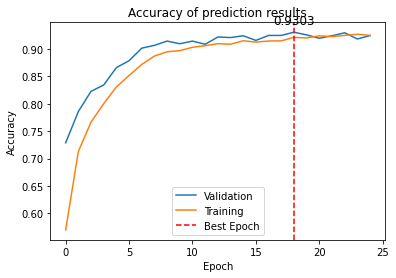

The highest validation accuracy is 0.9303


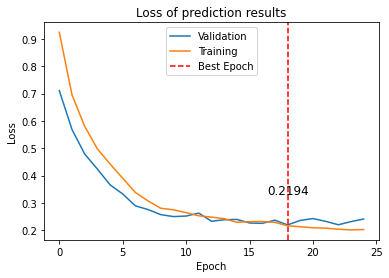

The lowest validation loss is 0.2194


In [12]:
# 对accuracy和val_accuracy作图
def plot_accuracy(epoch, val_accuracy, accuracy):
    best_epoch = 0
    max_accuracy = 0
    for i in range(len(epoch)):
        if val_accuracy[i] > max_accuracy:
            max_accuracy = val_accuracy[i]
            best_epoch = i
    plt.plot(epoch, val_accuracy, label='Validation')
    plt.plot(epoch, accuracy, label='Training')
    plt.axvline(x=epoch[best_epoch], color="r", ls="--", label='Best Epoch')
    plt.legend()
    # plt.ylim(0.4, 1)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy of prediction results')
    plt.text(best_epoch, max_accuracy + 0.01, '%.4f' %max_accuracy, ha='center', va='bottom', fontsize=12) # 最高val_accuracy对应epoch
    plt.show()
    print("The highest validation accuracy is %.4f" % max_accuracy)

# 对loss和val_loss作图
def plot_loss(epoch, val_loss, loss):
    best_epoch = 0
    min_loss = 1
    for i in range(len(epoch)):
        if val_loss[i] < min_loss:
            min_loss = val_loss[i]
            best_epoch = i
    plt.plot(epoch, val_loss, label='Validation')
    plt.plot(epoch, loss, label='Training')
    plt.axvline(x=epoch[best_epoch], color="r", ls="--", label='Best Epoch')
    plt.legend()
    # plt.ylim(0, 1.2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss of prediction results')
    plt.text(best_epoch, min_loss+0.1, '%.4f' % min_loss, ha='center', va='bottom', fontsize=12) # 最低val_loss对应epoch
    plt.show()
    print("The lowest validation loss is %.4f" % min_loss)

plot_accuracy(history.epoch, history.history['val_accuracy'], history.history['accuracy'])
plot_loss(history.epoch, history.history['val_loss'], history.history['loss'])